TASK 4 - PROXY TARGET VARIABLE ENGINEERING
Creating High-Risk Labels via RFM Clustering

1. LOADING PROCESSED FEATURES
Loading customer features from data/processed/customer_features.csv...
✓ Loaded features for 2,293 customers

Customer features shape: (2293, 20)
Available columns (20):
   1. CustomerId
   2. total_transaction_amount
   3. avg_transaction_amount
   4. std_transaction_amount
   5. min_transaction_amount
   6. max_transaction_amount
   7. transaction_count
   8. avg_transaction_value
   9. std_transaction_value
  10. first_transaction_date
  11. last_transaction_date
  12. most_common_productcategory
  13. most_common_channelid
  14. most_common_currencycode
  15. most_common_countrycode
  16. recency_days
  17. customer_tenure_days
  18. frequency_per_day
  19. avg_transaction_size
  20. transaction_range

2. SELECTING RFM FEATURES
✓ Selected Recency              → recency_days
✓ Selected Frequency            → frequency_per_day
✓ Selected Monetary             → total_

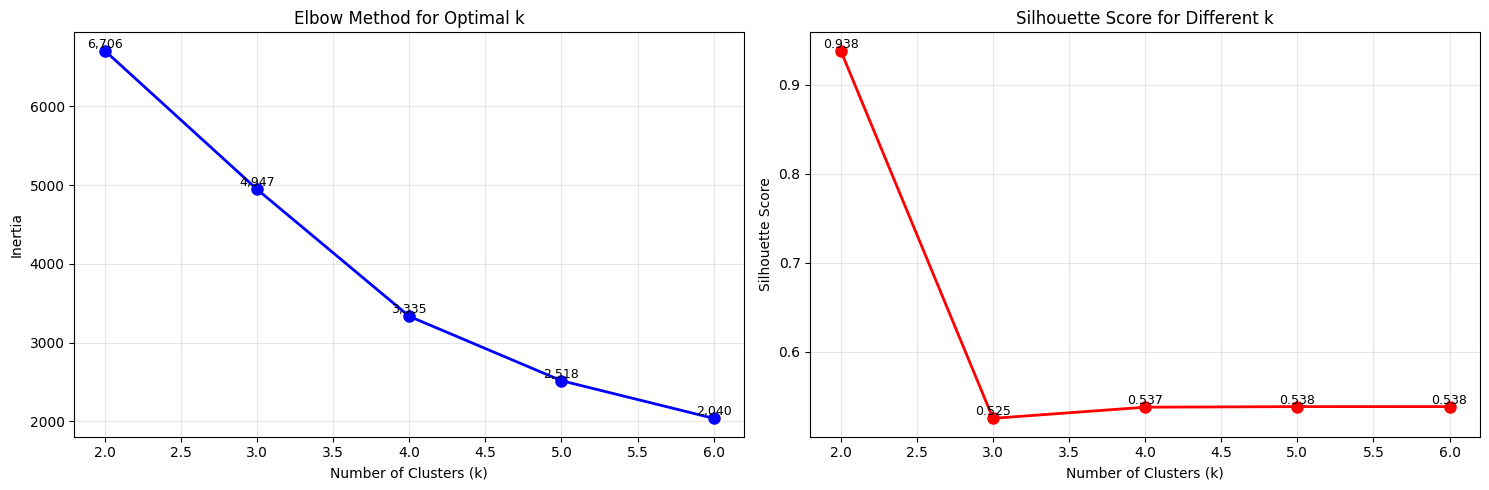

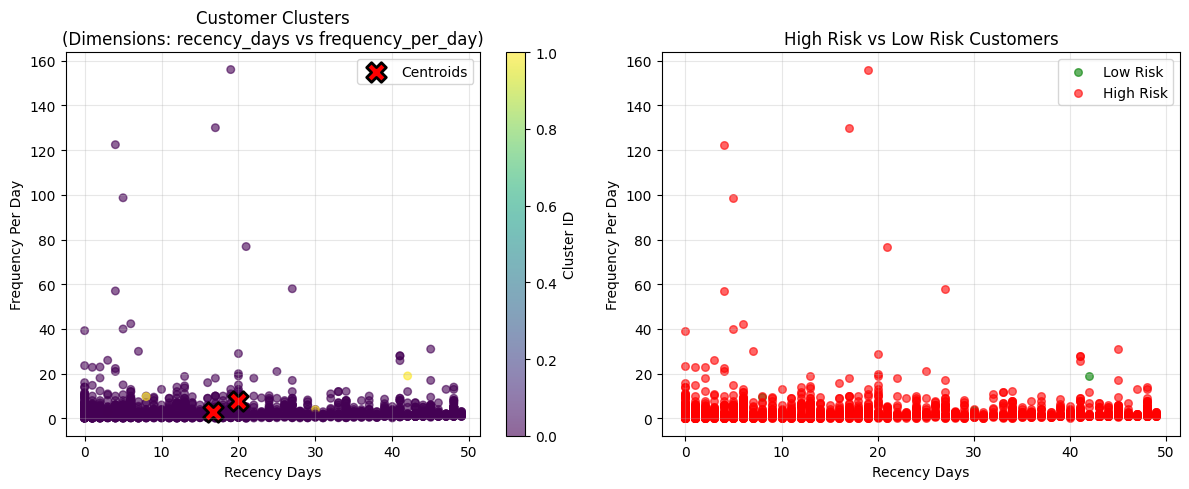

In [1]:
"""
Task 4 - Proxy Target Variable Engineering
Creating credit risk labels using RFM clustering
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
import os

print("=" * 70)
print("TASK 4 - PROXY TARGET VARIABLE ENGINEERING")
print("Creating High-Risk Labels via RFM Clustering")
print("=" * 70)

# -----------------------------
# 1. Load Processed Customer Features
# -----------------------------
print("\n" + "=" * 70)
print("1. LOADING PROCESSED FEATURES")
print("=" * 70)

# Try to load the customer features created in Task 3
customer_features_path = "data/processed/customer_features.csv"

if os.path.exists(customer_features_path):
    print(f"Loading customer features from {customer_features_path}...")
    customer_df = pd.read_csv(customer_features_path)
    print(f"✓ Loaded features for {len(customer_df):,} customers")
else:
    print(f"❌ File not found: {customer_features_path}")
    print("Please run Task 3 feature engineering first.")
    exit(1)

print(f"\nCustomer features shape: {customer_df.shape}")
print(f"Available columns ({len(customer_df.columns)}):")
for i, col in enumerate(customer_df.columns, 1):
    print(f"  {i:2}. {col}")

# -----------------------------
# 2. Select RFM Features for Clustering
# -----------------------------
print("\n" + "=" * 70)
print("2. SELECTING RFM FEATURES")
print("=" * 70)

# Define RFM features we want to use
rfm_features = []

# Check which RFM features exist in our dataset
possible_rfm_features = {
    'recency': ['recency_days', 'days_since_last_transaction', 'recency'],
    'frequency': ['frequency_per_day', 'transaction_count', 'total_transactions'],
    'monetary': ['total_transaction_amount', 'avg_transaction_amount', 'avg_transaction_size'],
    'standard_deviation': ['std_transaction_amount', 'transaction_volatility']
}

for dimension, feature_options in possible_rfm_features.items():
    found = False
    for option in feature_options:
        if option in customer_df.columns:
            rfm_features.append(option)
            print(f"✓ Selected {dimension.capitalize():20} → {option}")
            found = True
            break
    
    if not found:
        print(f"⚠ Warning: No {dimension} feature found in dataset")

# If we don't have enough features, create them
if len(rfm_features) < 3:
    print("\nCreating missing RFM features...")
    
    # Create frequency if missing
    if 'transaction_count' in customer_df.columns:
        if 'customer_tenure_days' in customer_df.columns:
            customer_df['frequency_per_day'] = (
                customer_df['transaction_count'] / 
                np.maximum(customer_df['customer_tenure_days'], 1)
            )
            rfm_features.append('frequency_per_day')
            print("✓ Created frequency_per_day")
    
    # Create recency if missing
    if 'last_transaction_date' in customer_df.columns:
        # Convert to datetime
        customer_df['last_transaction_date'] = pd.to_datetime(customer_df['last_transaction_date'])
        snapshot_date = customer_df['last_transaction_date'].max()
        customer_df['recency_days'] = (snapshot_date - customer_df['last_transaction_date']).dt.days
        rfm_features.append('recency_days')
        print("✓ Created recency_days")

print(f"\nFinal RFM features selected ({len(rfm_features)}):")
for feat in rfm_features:
    print(f"  - {feat}")

# -----------------------------
# 3. Prepare Data for Clustering
# -----------------------------
print("\n" + "=" * 70)
print("3. DATA PREPARATION FOR CLUSTERING")
print("=" * 70)

# Select only the RFM features
X_rfm = customer_df[rfm_features].copy()

print(f"Selected {X_rfm.shape[1]} features for {X_rfm.shape[0]} customers")

# Check for missing values
missing = X_rfm.isnull().sum()
if missing.sum() > 0:
    print(f"\n⚠ Missing values found:")
    for col in missing[missing > 0].index:
        print(f"  {col}: {missing[col]} missing ({missing[col]/len(X_rfm)*100:.1f}%)")
    
    # Handle missing values
    print("\nHandling missing values...")
    for col in rfm_features:
        if X_rfm[col].isnull().any():
            if 'std' in col or 'deviation' in col:
                # For std features, fill with 0 (no variation)
                X_rfm[col] = X_rfm[col].fillna(0)
                print(f"  Filled {col} with 0")
            else:
                # For other features, fill with median
                X_rfm[col] = X_rfm[col].fillna(X_rfm[col].median())
                print(f"  Filled {col} with median")
else:
    print("✓ No missing values found")

# Scale the features (important for K-Means)
print("\nScaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rfm)
print("✓ Features scaled using StandardScaler")

# -----------------------------
# 4. Determine Optimal Number of Clusters
# -----------------------------
print("\n" + "=" * 70)
print("4. DETERMINING OPTIMAL CLUSTER COUNT")
print("=" * 70)

# We'll test 2 to 6 clusters
k_range = range(2, 7)
inertia_values = []
silhouette_scores = []

print("Testing different cluster counts...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
    
    print(f"  k={k}: Inertia = {kmeans.inertia_:,.0f}, Silhouette = {silhouette_scores[-1]:.3f}")

# Plot elbow curve
print("\nCreating visualization...")
plt.figure(figsize=(15, 5))

# Elbow plot
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)

# Add annotations
for k, inertia in zip(k_range, inertia_values):
    plt.text(k, inertia, f'{inertia:,.0f}', ha='center', va='bottom', fontsize=9)

# Silhouette score plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.grid(True, alpha=0.3)

# Add annotations
for k, score in zip(k_range, silhouette_scores):
    plt.text(k, score, f'{score:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('data/processed/cluster_analysis.png', dpi=150, bbox_inches='tight')
print("✓ Saved cluster analysis plot to 'data/processed/cluster_analysis.png'")

# Determine optimal k (based on silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n✅ Optimal number of clusters: k = {optimal_k} (highest silhouette score)")

# -----------------------------
# 5. Perform K-Means Clustering
# -----------------------------
print("\n" + "=" * 70)
print("5. PERFORMING K-MEANS CLUSTERING")
print("=" * 70)

print(f"Running K-Means with {optimal_k} clusters...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
customer_df['cluster'] = cluster_labels
X_rfm['cluster'] = cluster_labels

print(f"✓ Clustering complete. Cluster distribution:")
cluster_counts = customer_df['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"  Cluster {cluster_id}: {count:5d} customers ({count/len(customer_df)*100:.1f}%)")

# -----------------------------
# 6. Analyze Cluster Characteristics
# -----------------------------
print("\n" + "=" * 70)
print("6. ANALYZING CLUSTER CHARACTERISTICS")
print("=" * 70)

print("Calculating cluster centroids...")
# Get scaled centroids
scaled_centroids = kmeans.cluster_centers_

# Convert back to original scale
original_centroids = scaler.inverse_transform(scaled_centroids)
centroid_df = pd.DataFrame(original_centroids, columns=rfm_features)
centroid_df['cluster'] = range(optimal_k)

print("\nCluster Centroids (original scale):")
print(centroid_df.to_string())

# Calculate mean values per cluster
print("\nAverage RFM values per cluster:")
cluster_stats = X_rfm.groupby('cluster')[rfm_features].mean()

# Add count to the stats
cluster_stats['customer_count'] = cluster_counts
cluster_stats['percentage'] = cluster_counts.values / len(customer_df) * 100

print(cluster_stats.to_string())

# -----------------------------
# 7. Identify High-Risk Cluster
# -----------------------------
print("\n" + "=" * 70)
print("7. IDENTIFYING HIGH-RISK CLUSTER")
print("=" * 70)

print("Analyzing cluster patterns to identify high-risk customers...")

# Define what makes a customer high-risk:
# 1. High recency (long time since last transaction) → disengaged
# 2. Low frequency (few transactions) → sporadic user
# 3. Low monetary value (small transactions) → low value
# 4. High standard deviation (inconsistent spending) → unstable

# For each RFM dimension, determine if high values are good or bad
# (We'll reverse recency since higher recency = worse)
rfm_direction = {
    'recency_days': 'lower_is_better',  # Lower recency = more recent = better
    'frequency_per_day': 'higher_is_better',  # Higher frequency = more active = better
    'total_transaction_amount': 'higher_is_better',  # Higher spending = better
    'avg_transaction_amount': 'higher_is_better',  # Higher average = better
    'std_transaction_amount': 'lower_is_better',  # Lower std = more consistent = better
    'transaction_count': 'higher_is_better'  # More transactions = better
}

# Score each cluster
cluster_scores = {}
for cluster_id in range(optimal_k):
    score = 0
    for feature in rfm_features:
        if feature in rfm_direction:
            cluster_value = cluster_stats.loc[cluster_id, feature]
            overall_mean = X_rfm[feature].mean()
            
            if rfm_direction[feature] == 'lower_is_better':
                # Lower values are better
                if cluster_value < overall_mean:
                    score += 1  # Better than average
                else:
                    score -= 1  # Worse than average
            else:  # higher_is_better
                # Higher values are better
                if cluster_value > overall_mean:
                    score += 1  # Better than average
                else:
                    score -= 1  # Worse than average
    
    cluster_scores[cluster_id] = score
    print(f"  Cluster {cluster_id}: Risk score = {score:+.1f}")

# Identify the worst cluster (lowest score = highest risk)
high_risk_cluster = min(cluster_scores, key=cluster_scores.get)
print(f"\n✅ High-risk cluster identified: Cluster {high_risk_cluster}")

# -----------------------------
# 8. Create Target Variable
# -----------------------------
print("\n" + "=" * 70)
print("8. CREATING TARGET VARIABLE")
print("=" * 70)

# Create binary target variable
customer_df['is_high_risk'] = (customer_df['cluster'] == high_risk_cluster).astype(int)

print(f"Target variable distribution:")
risk_counts = customer_df['is_high_risk'].value_counts()
for risk_level, count in risk_counts.items():
    label = "High Risk" if risk_level == 1 else "Low Risk"
    print(f"  {label}: {count:5d} customers ({count/len(customer_df)*100:.1f}%)")

# Check class imbalance
imbalance_ratio = risk_counts[1] / risk_counts[0]
print(f"\nClass imbalance ratio (High:Low): 1:{1/imbalance_ratio:.1f}")

if imbalance_ratio < 0.2 or imbalance_ratio > 0.8:
    print("⚠ Warning: Significant class imbalance detected")
    print("Consider using class weighting or sampling techniques during model training")

# -----------------------------
# 9. Visualize the Clusters
# -----------------------------
print("\n" + "=" * 70)
print("9. VISUALIZING CLUSTERS")
print("=" * 70)

# Create scatter plots to visualize clusters
print("Creating cluster visualizations...")

# Select two main dimensions for visualization
if len(rfm_features) >= 2:
    # Choose the first two RFM features
    dim1, dim2 = rfm_features[0], rfm_features[1]
    
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Clusters colored by cluster ID
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(
        customer_df[dim1], 
        customer_df[dim2], 
        c=customer_df['cluster'], 
        cmap='viridis', 
        alpha=0.6,
        s=30
    )
    plt.xlabel(dim1.replace('_', ' ').title())
    plt.ylabel(dim2.replace('_', ' ').title())
    plt.title(f'Customer Clusters\n(Dimensions: {dim1} vs {dim2})')
    plt.colorbar(scatter, label='Cluster ID')
    plt.grid(True, alpha=0.3)
    
    # Plot centroids
    centroids = customer_df.groupby('cluster')[[dim1, dim2]].mean()
    plt.scatter(
        centroids[dim1], 
        centroids[dim2], 
        c='red', 
        marker='X', 
        s=200, 
        label='Centroids',
        edgecolors='black',
        linewidth=2
    )
    plt.legend()
    
    # Plot 2: Clusters colored by risk
    plt.subplot(1, 2, 2)
    colors = ['green', 'red']
    risk_labels = ['Low Risk', 'High Risk']
    
    for risk_level in [0, 1]:
        mask = customer_df['is_high_risk'] == risk_level
        plt.scatter(
            customer_df.loc[mask, dim1], 
            customer_df.loc[mask, dim2], 
            c=colors[risk_level], 
            label=risk_labels[risk_level],
            alpha=0.6,
            s=30
        )
    
    plt.xlabel(dim1.replace('_', ' ').title())
    plt.ylabel(dim2.replace('_', ' ').title())
    plt.title('High Risk vs Low Risk Customers')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('data/processed/cluster_visualization.png', dpi=150, bbox_inches='tight')
    print("✓ Saved cluster visualization to 'data/processed/cluster_visualization.png'")

# -----------------------------
# 10. Save Results
# -----------------------------
print("\n" + "=" * 70)
print("10. SAVING RESULTS")
print("=" * 70)

# Create processed directory if it doesn't exist
os.makedirs('data/processed', exist_ok=True)

# Save customer data with risk labels
output_path = 'data/processed/customers_with_risk_labels.csv'
customer_df.to_csv(output_path, index=False)
print(f"✓ Saved customer data with risk labels to {output_path}")

# Save RFM features used
rfm_features_path = 'data/processed/rfm_features_used.csv'
pd.DataFrame({'feature': rfm_features}).to_csv(rfm_features_path, index=False)
print(f"✓ Saved RFM features list to {rfm_features_path}")

# Save cluster statistics
cluster_stats_path = 'data/processed/cluster_statistics.csv'
cluster_stats.to_csv(cluster_stats_path)
print(f"✓ Saved cluster statistics to {cluster_stats_path}")

# Save target variable separately
target_path = 'data/processed/target_variable.csv'
customer_df[['CustomerId', 'is_high_risk']].to_csv(target_path, index=False)
print(f"✓ Saved target variable to {target_path}")

# -----------------------------
# 11. Summary Report
# -----------------------------
print("\n" + "=" * 70)
print("PROXY TARGET ENGINEERING COMPLETE - SUMMARY")
print("=" * 70)

print(f"\n📊 CLUSTERING RESULTS")
print(f"   Total customers: {len(customer_df):,}")
print(f"   Optimal clusters: {optimal_k}")
print(f"   High-risk cluster: {high_risk_cluster}")

print(f"\n🎯 RISK DISTRIBUTION")
high_risk_count = risk_counts[1]
low_risk_count = risk_counts[0]
print(f"   High-risk customers: {high_risk_count:,} ({high_risk_count/len(customer_df)*100:.1f}%)")
print(f"   Low-risk customers: {low_risk_count:,} ({low_risk_count/len(customer_df)*100:.1f}%)")

print(f"\n📈 HIGH-RISK CLUSTER CHARACTERISTICS")
high_risk_stats = cluster_stats.loc[high_risk_cluster]
for feature in rfm_features:
    value = high_risk_stats[feature]
    overall_mean = X_rfm[feature].mean()
    diff_pct = (value - overall_mean) / overall_mean * 100
    
    # Interpret the difference
    if feature in rfm_direction:
        if rfm_direction[feature] == 'lower_is_better' and value > overall_mean:
            direction = "↑ WORSE"
        elif rfm_direction[feature] == 'higher_is_better' and value < overall_mean:
            direction = "↓ WORSE"
        else:
            direction = "✓ BETTER"
    else:
        direction = ""
    
    print(f"   {feature:25} {value:10.2f} ({diff_pct:+.1f}%) {direction}")

print(f"\n💾 FILES CREATED")
print(f"   1. {output_path} - Complete dataset with risk labels")
print(f"   2. {target_path} - Target variable for modeling")
print(f"   3. data/processed/cluster_analysis.png - Elbow & silhouette plots")
print(f"   4. data/processed/cluster_visualization.png - 2D cluster visualization")
print(f"   5. {cluster_stats_path} - Detailed cluster statistics")
print(f"   6. {rfm_features_path} - List of RFM features used")

print(f"\n" + "=" * 70)
print("NEXT STEP: Task 5 - Model Training and Tracking")
print("=" * 70)
print(f"\nReady for model training!")
print(f"Use 'customers_with_risk_labels.csv' as input for model training.")
print(f"Target variable: 'is_high_risk' (1 = high risk, 0 = low risk)")